<a href="https://colab.research.google.com/github/dajebbar/FreeCodeCamp-python-data-analysis/blob/main/Exercise_M2_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this exercise is to make the following experiments:

train and test a support vector machine classifier through cross-validation;
study the effect of the parameter gamma of this classifier using a validation curve;
use a learning curve to determine the usefulness of adding new samples in the dataset when building a classifier.
To make these experiments we will first load the blood transfusion dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
blood_transfusion = pd.read_csv('./blood_transfusion.csv')
blood_transfusion.head()

,V1,V2,V3,V4,Class
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1


In [3]:
blood_transfusion.rename(columns={
    'V1':'Recency',
    'V2':'Frequency',
    'V3': 'Monetary',
    'V4': 'Time',
}, inplace=True)

blood_transfusion.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1


In [4]:
blood_transfusion.shape

(748, 5)

In [5]:
blood_transfusion.dtypes.value_counts()

int64    5
dtype: int64

In [6]:
blood_transfusion.isna().sum()

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

In [7]:
blood_transfusion.Class.value_counts()

1    570
2    178
Name: Class, dtype: int64

In [8]:
data = blood_transfusion.drop('Class', axis=1)
target = blood_transfusion.Class

We will use a support vector machine classifier (SVM). In its most simple form, a SVM classifier is a linear classifier behaving similarly to a logistic regression. Indeed, the optimization used to find the optimal weights of the linear model are different.
Also, this classifier can become more flexible/expressive by using a so-called kernel that makes the model become non-linear.

We will use an RBF kernel where a parameter gamma allows to tune the flexibility of the model.

First let's create a predictive pipeline made of:

- a `sklearn.preprocessing.StandardScaler` with default parameter;
- a `sklearn.svm.SVC` where the parameter `kernel` could be set to "`rbf`". Note that this is the default.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm


num_scaler = StandardScaler()
clf = make_pipeline(num_scaler, svm.SVC(kernel='rbf'))
clf

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

Evaluate the generalization performance of your model by cross-validation with a `ShuffleSplit` scheme. Thus, you can use sklearn.`model_selection.cross_validate` and pass a `sklearn.model_selection.ShuffleSplit` to the cv parameter. Only fix the `random_state=0` in the ShuffleSplit and let the other parameters to the default.

In [10]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=10, random_state=0)
cv_results = cross_validate(clf,
                            data,
                            target,
                            cv=cv,
                            n_jobs=2)

cv_results

{'fit_time': array([0.05585241, 0.06876397, 0.04159784, 0.03969169, 0.04837203,
        0.05312395, 0.04761648, 0.06356525, 0.03999996, 0.04171681]),
 'score_time': array([0.00656176, 0.01421499, 0.00636053, 0.00649047, 0.00630474,
        0.00641608, 0.00657511, 0.0063715 , 0.01360798, 0.00642252]),
 'test_score': array([0.68      , 0.74666667, 0.78666667, 0.8       , 0.74666667,
        0.78666667, 0.8       , 0.82666667, 0.74666667, 0.73333333])}

In [11]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.055852,0.006562,0.680000
1,0.068764,0.014215,0.746667
2,0.041598,0.006361,0.786667
3,0.039692,0.006490,0.800000
4,0.048372,0.006305,0.746667
5,0.053124,0.006416,0.786667
6,0.047616,0.006575,0.800000
7,0.063565,0.006371,0.826667
8,0.040000,0.013608,0.746667
9,0.041717,0.006423,0.733333


In [12]:
%%time
from sklearn.model_selection import validation_curve

svc__gamma = np.logspace(-3, 2, num=30)

train_scores, test_scores = validation_curve(
    clf,
    data,
    target,
    param_name='svc__gamma',
    param_range=svc__gamma,
    cv=cv,
    n_jobs=2
)

CPU times: user 1.84 s, sys: 77.2 ms, total: 1.92 s
Wall time: 16.3 s


Text(0.5, 1.0, 'Validation curve of Support Vector Machine')

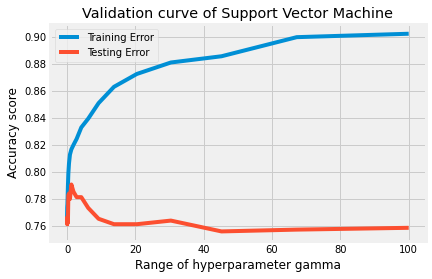

In [20]:
plt.plot(svc__gamma, train_scores.mean(axis=1), label='Training Error')
plt.plot(svc__gamma, test_scores.mean(axis=1), label='Testing Error')
plt.legend()

plt.ylabel('Accuracy score')
plt.xlabel('Range of hyperparameter gamma')
plt.title('Validation curve of Support Vector Machine')

Text(0.5, 1.0, 'Validation curve of Support Vector Machine')

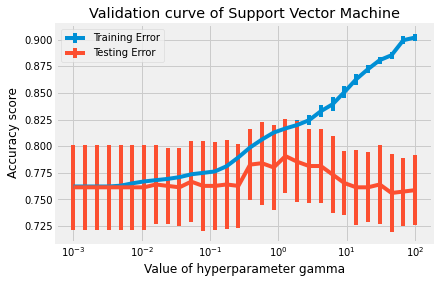

In [18]:
plt.errorbar(svc__gamma, 
             train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1),
             label='Training Error')
plt.errorbar(svc__gamma, 
             test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1),
             label='Testing Error')
plt.legend()

plt.xscale('log')
plt.ylabel('Accuracy score')
plt.xlabel('Value of hyperparameter gamma')
plt.title('Validation curve of Support Vector Machine')

Looking at the curve, we can clearly identify the over-fitting regime of the SVC classifier when `gamma > 1`. The best setting is around `gamma = 1` while for `gamma < 1`, it is not very clear if the classifier is under-fitting but the **testing score** is worse than for `gamma = 1`.

Now, you can perform an analysis to check whether adding new samples to the dataset could help our model to better generalize. Compute the learning curve (using `sklearn.model_selection.learning_curve`) by computing the train and test scores for different training dataset size. Plot the train and test scores with respect to the number of samples.

Text(0.5, 1.0, 'Learning curve for SVM')

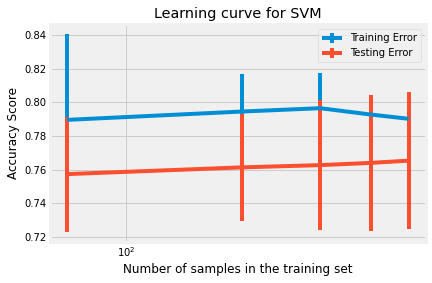

In [21]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
results = learning_curve(
    clf,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    n_jobs=2
)

train_sizes, train_scores, test_scores = results[:3]

plt.errorbar(train_sizes,
              train_scores.mean(axis=1),
              yerr=train_scores.std(axis=1),
              label='Training Error')

plt.errorbar(train_sizes,
             test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1),
             label='Testing Error')

plt.legend()


plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy Score")
plt.title("Learning curve for SVM")

We observe that adding new samples in the dataset does not improve the testing score. We can only conclude that the standard deviation of the training error is decreasing when adding more samples which is not a surprise.